<a href="https://colab.research.google.com/github/cjrincon/Proyecto_Deep_Learning/blob/main/03_Predicci%C3%B3n_del_RUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predecir la capacidad de la batería**

Se plantean diferentes modelos para hacer la predicción del RUL teniendo en cuenta datos anteriores de la capacidad.


## Cargar las librerías necesarias para el desarrollo del proyecto

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math, statistics

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Lectura de los datos, identificación de cada batería y cálculo del SOH

In [ ]:
# Lectura de datos desde github
# Datos de la batería #5
url_5 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_05.csv'
bat_5 = pd.read_csv(url_5, delimiter=',')
# Datos de la batería #6
url_6 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_06.csv'
bat_6 = pd.read_csv(url_6, delimiter=',')
# Datos de la batería #7
url_7 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_07.csv'
bat_7 = pd.read_csv(url_7, delimiter=',')
# Datos de la batería #18
url_18 = 'https://raw.githubusercontent.com/cjrincon/Proyecto_Deep_Learning/main/data/raw_data_18.csv'
bat_18 = pd.read_csv(url_18, delimiter=',')

In [ ]:
# Se agrega una columna para identificar cada tipo de batería
bat_5 = bat_5.assign(battery=5)
bat_6 = bat_6.assign(battery=6)
bat_7 = bat_7.assign(battery=7)
bat_18 = bat_18.assign(battery=18)

In [ ]:
# Se crea una base de datos consolidando los datos de las 4 baterías
data = pd.concat([bat_5, bat_6, bat_7, bat_18])
data.head()

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time,battery
0,1,24,2008-04-02 15:25:41,1.856487,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,5
1,1,24,2008-04-02 15:25:41,1.856487,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,5
2,1,24,2008-04-02 15:25:41,1.856487,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,5
3,1,24,2008-04-02 15:25:41,1.856487,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,5
4,1,24,2008-04-02 15:25:41,1.856487,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,5


In [ ]:
# Se calcula el SOH según la fórmula anterior
bat_5['SOH'] = bat_5['capacity']/bat_5['capacity'][0]
bat_6['SOH'] = bat_6['capacity']/bat_5['capacity'][0]
bat_7['SOH'] = bat_7['capacity']/bat_5['capacity'][0]
bat_18['SOH'] = bat_18['capacity']/bat_5['capacity'][0]
data = pd.concat([bat_5, bat_6, bat_7, bat_18])

## Definición del conjunto de datos para cada batería

In [ ]:
data_5_RUL = bat_5.groupby(by=['cycle'])['capacity'].mean()
data_5_RUL = data_5_RUL.reset_index()
data_5_RUL['capacity'] = data_5_RUL['capacity']
data_5_RUL = data_5_RUL.set_index('cycle')
data_5_RUL.shape

(168, 1)

In [ ]:
data_6_RUL = bat_6.groupby(by=['cycle'])['capacity'].mean()
data_6_RUL = data_6_RUL.reset_index()
data_6_RUL['capacity'] = data_6_RUL['capacity']
data_6_RUL = data_6_RUL.set_index('cycle')
data_6_RUL.shape

(168, 1)

In [ ]:
data_7_RUL = bat_7.groupby(by=['cycle'])['capacity'].mean()
data_7_RUL = data_7_RUL.reset_index()
data_7_RUL['capacity'] = data_7_RUL['capacity']
data_7_RUL = data_7_RUL.set_index('cycle')
data_7_RUL.shape

(168, 1)

In [ ]:
data_18_RUL = bat_18.groupby(by=['cycle'])['capacity'].mean()
data_18_RUL = data_18_RUL.reset_index()
data_18_RUL['capacity'] = data_18_RUL['capacity']
data_18_RUL = data_18_RUL.set_index('cycle')
data_18_RUL.shape

(132, 1)

## Definición de funciones necesarias

In [ ]:
def create_datasetMultipleTimesBackAhead(dataset, n_steps_out=1, n_steps_in = 1, overlap = 1):
	dataX, dataY = [], []
	tem = n_steps_in + n_steps_out - overlap
	for i in range(int((len(dataset) - tem)/overlap)):
		startx = i*overlap
		endx = startx + n_steps_in
		starty = endx
		endy = endx + n_steps_out
		a = dataset[startx:endx, 0]
		dataX.append(a)
		dataY.append(dataset[starty:endy, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
def EstimaRMSE_RNN_MultiStep(model,X_train,X_test,y_train,y_test,scaler,look_back,n_steps,flag):
	# make predictions
	if flag == 1:#multiple times set as features
		trainPredict = model.predict(X_train.reshape(X_train.shape[0],1,look_back))
		testPredict = []
		for i in range(X_test.shape[0]):
			temPredict = np.zeros([n_steps])
			for j in range(n_steps):
				if j==0:
					xtest = X_test[i,:]
				else:
					xtest = np.concatenate((X_test[i,j:],temPredict[:j]))
				temPredict[j] = model.predict(xtest.reshape(1,1,look_back))
			testPredict.append(temPredict)
		testPredict = np.array(testPredict)
		testPredict = testPredict.flatten()
	else: #multiple times set as times
		trainPredict = model.predict(X_train.reshape(X_train.shape[0],look_back,1))
		testPredict = []
		for i in range(X_test.shape[0]):
			temPredict = np.zeros([n_steps])
			for j in range(n_steps):
				if j==0:
					xtest = X_test[i,:]
				else:
					xtest = np.concatenate((X_test[i,j:],temPredict[:j]))
				temPredict[j] = model.predict(xtest.reshape(1,look_back,1))
			testPredict.append(temPredict)
		testPredict = np.array(testPredict)
		testPredict = testPredict.flatten()

	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
	trainY = scaler.inverse_transform(y_train)
	testPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
	testY = scaler.inverse_transform(y_test.flatten().reshape(-1, 1))
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1, 1), trainPredict.reshape(-1, 1)))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY.reshape(-1, 1), testPredict.reshape(-1, 1)))
	print('Test Score: %.2f RMSE' % (testScore))
	return trainPredict, testPredict

In [ ]:
def PintaResultado(dataset,trainPredict,testPredict,look_back):
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset+1)
	testPredictPlot[:, :] = np.nan
	Ntest = len(testPredict)
	NtestSpace = len(dataset)+1 - (len(trainPredict)+(look_back*2))
	restante = NtestSpace - Ntest
	print(restante)
	testPredictPlot[len(dataset)-len(testPredict):len(dataset)+1, :] = testPredict
	# plot baseline and predictions
	plt.figure(figsize=(10,4))
	plt.plot(dataset,label='Original Time serie')
	plt.plot(trainPredictPlot,label='Training prediction')
	plt.plot(testPredictPlot,label='Test prediction')
	plt.legend()
	plt.show()

## División de los datos

Para la división de los datos, se tiene en cuenta los datos de la batería #5 para el entrenamiento y los datos de la batería #6 para el test, teniendo en cuenta que ambos conjuntos de baterías tienen la misma distribución y el mismo comportamiento decreciente de la capacidad.

In [ ]:
look_back = 15
time_ahead = 15
train = data_5_RUL
test = data_6_RUL
print(train.shape, test.shape)

(168, 1) (168, 1)


In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [ ]:
X_train, y_train = split_sequence(train_n, look_back)
print(X_train.shape, y_train.shape)

(153, 15, 1) (153, 1)


In [ ]:
X_test, y_test = create_datasetMultipleTimesBackAhead(test_n, n_steps_out=time_ahead, n_steps_in = look_back, overlap = time_ahead)
print(X_test.shape, y_test.shape)

(10, 15) (10, 15)


## Modelo de predicción usando la capa recurrente

In [ ]:
modelo = Sequential()
modelo.add(SimpleRNN(20,activation = 'relu',input_shape=(look_back,1)))
modelo.add(Dropout(0.2))
modelo.add(Dense(1))

In [ ]:
modelo.compile(optimizer='adam',loss='mse')
modelo.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train.flatten(),epochs=500, verbose=False)

In [ ]:
trainPredict, testPredict = EstimaRMSE_RNN_MultiStep(modelo,X_train,X_test,y_train,y_test,scaler,look_back,time_ahead,0)

Train Score: 0.02 RMSE
Test Score: 0.07 RMSE


-164


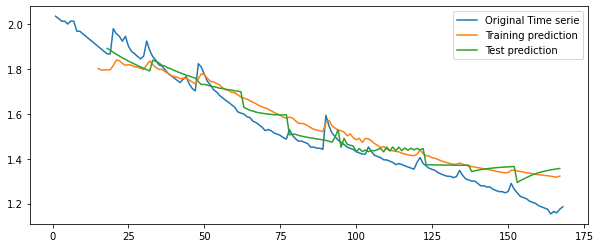

In [ ]:
PintaResultado(data_6_RUL,trainPredict,testPredict,look_back)

Según los resultados, el RMSE para el entrenamiento es 2% y para el test es del 9%. Según la gráfica, se observa que la predicción se ajusta a los datos reales, con diferencias en algunas partes de la predicción. Sin embargo, el modelo predice el comportamiento decreciente de la capacidad.


## Modelo de predicción usando las capas LSTM

In [ ]:
# Se implementa un modelo teniendo en cuenta capas LSTM
modelo_LSTM = Sequential()
modelo_LSTM.add(LSTM(128, input_shape = (X_train.shape[1],1), return_sequences=True, activation = "tanh"))
modelo_LSTM.add(LSTM(64, activation = "tanh", return_sequences = True))
modelo_LSTM.add(LSTM(32, activation = "tanh"))
modelo_LSTM.add(Dense(96, activation = "relu"))
modelo_LSTM.add(Dense(128, activation = "relu"))
modelo_LSTM.add(Dense(units=1))

In [ ]:
# Se compila el modelo
modelo_LSTM.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')
modelo_LSTM.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train.flatten(),epochs=500, verbose=False)

In [ ]:
trainPredict_LSTM, testPredict_LSTM = EstimaRMSE_RNN_MultiStep(modelo_LSTM,X_train,X_test,y_train,y_test,scaler,look_back,time_ahead,0)

Train Score: 0.01 RMSE
Test Score: 0.09 RMSE


-164


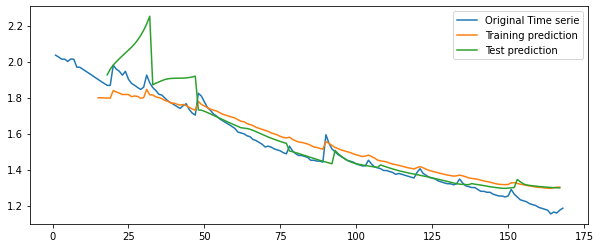

In [ ]:
PintaResultado(data_6_RUL,trainPredict_LSTM,testPredict_LSTM,look_back)

Con el modelo de capas LSTM, se observa que se obtiene un RMSE del 1% para los datos de entrenamiento y para los datos de test, se obtiene un RMSE del 5%. En este caso, se observa un mejor nivel de predicción usando las capas LSTM, ya que es capaz de capturar el comportamiento decreciente de la capacidad.

Así mismo, la predicción se ve más suavizada en comparación con la predicción obtenida en el modelo anterior.

**Conclusión:** Con los modelos definidos anteriormente, se observa que se captura el comportamiento decreciente de la capacidad de la batería y según el RMSE calculado para el conjunto de test, se observa un buen error y gráficamente un buen ajuste en la predicción, teniendo en cuenta que se está prediciendo la capacidad a los 15 ciclos siguientes.

Además, se observa un mejor comportamiento en la predicción usando el modelo con capas LSTM en comparación con el modelo obtenido con la capa recurrente. En este caso, se demuestra que para predecir varios tiempos a futuro, las capas LSTM tienen una mejor precisión en la predicción, ya que son capaces de capturar el comportamiento decreciente de la batería.